# Generar logs

In [46]:
MAJOR = 'Computación comunes'

In [47]:
# Leer los majors desde el archivo
import json
import pandas as pd

with open('majors.json', 'r', encoding='utf-8') as json_majors:
    j = json_majors.read()
    majors = json.loads(j)
        
df_major = pd.read_csv("data/{}.csv".format(MAJOR))

In [48]:
global combinations
combinations = []
def combine(terms, accum):
    if type(terms[0]) == list:
        for i in range(len(terms[0])):
            item = accum + [terms[0][i]]
            if len(terms) == 1:
                combinations.append(item)
            else:
                combine(terms[1:], item)
    else:
        accum.append(terms[0])
        if len(terms) == 1:
            combinations.append(accum)
        else:
            combine(terms[1:], accum)


In [49]:
stg = df_major.groupby('ID')
total = []
for student, group in stg:
    cursoxalum = []
    last_course = 0
    for row in group.itertuples():
        if row.DURACIÓN != last_course:
            last_course = row.DURACIÓN
            cursoxalum.append((student, row.DURACIÓN, row.SIGLA))
        else:
            if type(cursoxalum[-1]) == tuple:
                cursoxalum[-1] = [cursoxalum[-1], (student, row.DURACIÓN, row.SIGLA)]
            else:
                cursoxalum[-1].append((student, row.DURACIÓN, row.SIGLA))
    total.append(cursoxalum)

In [50]:
trazas_total = []
combinations = []
for student in total:
    combine(student, [])
    trazas_total.append(combinations)
    combinations = []

In [51]:
row_list = []
i = 0
for student in trazas_total:
    for traza in student:
        for curso in traza:
            row_list.append({'case:concept:name': i, 'ID_ALUMNO': curso[0], 'concept:name': curso[2], 'time:timestamp': curso[1]})
        i += 1
A = pd.DataFrame(row_list)

In [52]:
A.to_csv('data/{} - log.csv'.format(MAJOR))

### Cálculo con Heuristic Miner

In [95]:
!pip install pm4py

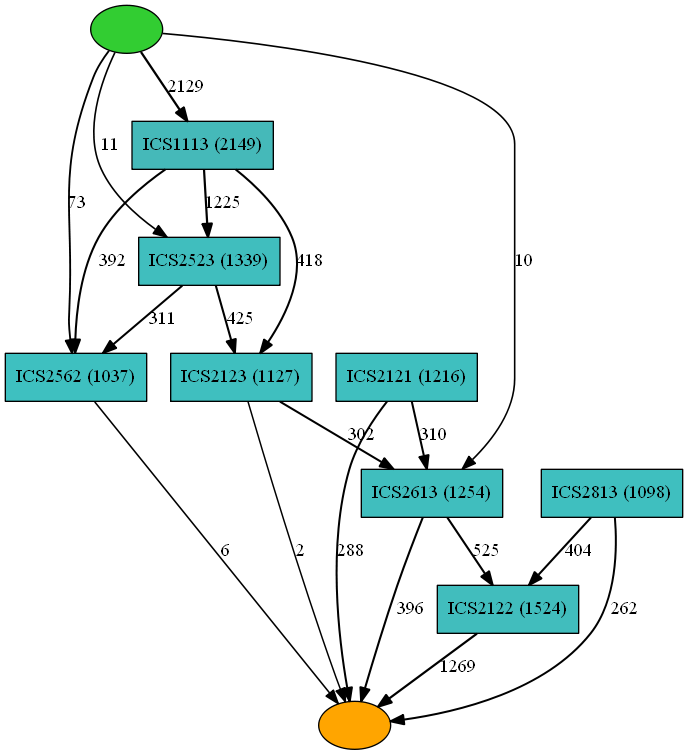

In [52]:
from pm4py.algo.discovery.heuristics import factory as heuristics_miner
from pm4py.objects.log.adapters.pandas import csv_import_adapter
from pm4py.objects.conversion.log import factory as conversion_factory
from pm4py.visualization.petrinet import factory as pn_vis_factory
from pm4py.visualization.heuristics_net import factory as hn_vis_factory
from pm4py.util import constants
import os
os.environ["PATH"] += os.pathsep + 'C:/Archivos de Programa/GraphViz/bin/'

dataframe = csv_import_adapter.import_dataframe_from_path(
    'cursos.csv', sep=",")
log = conversion_factory.apply(dataframe, parameters={constants.PARAMETER_CONSTANT_CASEID_KEY: "case:concept:name",
                                                      constants.PARAMETER_CONSTANT_ACTIVITY_KEY: "concept:name",
                                                      constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: "time:timestamp"})


net = heuristics_miner.apply_heu(
    log, parameters={"dependency_thresh": 0.1, "dfg_pre_cleaning_noise_thresh": 0.65, "min_dfg_occurrences":300})
gviz = hn_vis_factory.apply(net)
hn_vis_factory.view(gviz)